# Canny Benchmark

## Imports & Setup

In [1]:
%load_ext autoreload
%autoreload 2

import sys
import os

sys.path.append("../")

if False:
    # Enable the CUDA simulator
    os.environ["NUMBA_OPT"] = "0"
    os.environ["NUMBA_ENABLE_CUDASIM"] = "1"
    os.environ["NUMBA_CUDA_DEBUGINFO"] = "1"

import logging
import time
import pathlib
from pathlib import Path
import importlib.util
from importlib import reload
import math
from io import BytesIO
import unittest.mock as mock
import gc

import matplotlib as mpl
import matplotlib.pyplot as plt

from icecream import ic

import numpy as np
import pandas as pd
import scipy as sp
import numba
from numba import cuda

import cv2

from IPython.display import clear_output, display, Image
import ipywidgets as widgets
from PIL import Image as PILImage

from utils.benchmarking import time_function, time_line
from utils.setup_notebook import init_notebook, source_code_path_is_from_notebook
from utils.setup_logging import setup_logging
from utils.plotting_tools import (
    SmartFigure,
    to_ipy_image,
    plot_image,
    plot_kernel,
    plot_matrix,
)

init_notebook()
setup_logging("INFO")


## Loading Canny Implementations

In [2]:
# Load canny implementations
dir_canny_impls = "./canny_impls"
files_canny_impls = [f for f in os.listdir(dir_canny_impls) if str(f).endswith(".py")]
files_canny_impls.sort()

if "canny_impls" not in locals():
    canny_impls = []


def load_module(file_path: str, dyn_modules: list):
    module_name = Path(file_path).stem
    module_string = f"{module_name}"

    already_loaded = module_string in sys.modules
    if already_loaded:
        with time_line(f"Reloading {module_name}"):
            module = sys.modules[module_string]
            reload(module)
        return module

    with time_line(f"Loading {module_name}"):
        folder = str(Path(file_path).parent)
        if folder not in sys.path:
            sys.path.append(folder)
        spec = importlib.util.spec_from_file_location(module_string, file_path)
        module = importlib.util.module_from_spec(spec)
        sys.modules[module_string] = module
        spec.loader.exec_module(module)

    dyn_modules.append(module)

    return module


with time_line(f"Loading {len(files_canny_impls)} canny implementations"):
    for f in files_canny_impls:
        full_path = Path(dir_canny_impls) / f
        module = load_module(full_path, canny_impls)


2024-10-22 14:53:52.329 INFO root Loading 2 canny implementations started (C:\Users\_\AppData\Local\Temp\ipykernel_39148\3814923242.py:35)
2024-10-22 14:53:52.366 INFO root Loading rd_numba_cuda_fp32 started (C:\Users\_\AppData\Local\Temp\ipykernel_39148\3814923242.py:21)
2024-10-22 14:53:52.371 INFO numba.cuda.cudadrv.driver init
2024-10-22 14:53:54.411 INFO root Loading rd_numba_cuda_fp32 took: 2.0435 s (C:\Users\_\AppData\Local\Temp\ipykernel_39148\3814923242.py:21)
2024-10-22 14:53:54.459 INFO root Loading rd_vec_v4_dibit started (C:\Users\_\AppData\Local\Temp\ipykernel_39148\3814923242.py:21)
2024-10-22 14:53:55.175 INFO root Loading rd_vec_v4_dibit took: 714.8797 ms (C:\Users\_\AppData\Local\Temp\ipykernel_39148\3814923242.py:21)
2024-10-22 14:53:55.176 INFO root Loading 2 canny implementations took: 2.8455 s (C:\Users\_\AppData\Local\Temp\ipykernel_39148\3814923242.py:35)


## Loading Input Images

In [3]:
image_input_dir = "./image_input"
input_files = [
    f for f in os.listdir(image_input_dir) if f.endswith(".jpg") or f.endswith(".png")
]
input_files.sort()

images_color = []
images_gray = []

with time_line(f"Loading {len(input_files)} images"):
    for f in input_files:
        with time_line(f"Loading {f}"):
            file_image = Path(image_input_dir) / f
            image_color = cv2.imread(str(file_image), cv2.IMREAD_COLOR)
            images_color.append(image_color)
            # image_gray = (
            #    cv2.cvtColor(image_color, cv2.COLOR_BGR2GRAY).astype(np.float32) / 255.0
            # )
            image_gray = cv2.cvtColor(image_color, cv2.COLOR_BGR2GRAY)
            images_gray.append(image_gray)

# sort all three lists by image size
images_color, images_gray, input_files = zip(
    *sorted(zip(images_color, images_gray, input_files), key=lambda x: x[0].size)
)

2024-10-22 14:53:55.622 INFO root Loading 5 images started (C:\Users\_\AppData\Local\Temp\ipykernel_39148\2264552153.py:10)
2024-10-22 14:53:55.650 INFO root Loading circle_128.png started (C:\Users\_\AppData\Local\Temp\ipykernel_39148\2264552153.py:12)
2024-10-22 14:53:55.651 INFO root Loading circle_128.png took: 1.2607 ms (C:\Users\_\AppData\Local\Temp\ipykernel_39148\2264552153.py:12)
2024-10-22 14:53:55.686 INFO root Loading circle_32.png started (C:\Users\_\AppData\Local\Temp\ipykernel_39148\2264552153.py:12)
2024-10-22 14:53:55.688 INFO root Loading circle_32.png took: 916.2000 µs (C:\Users\_\AppData\Local\Temp\ipykernel_39148\2264552153.py:12)
2024-10-22 14:53:55.720 INFO root Loading circle_64.png started (C:\Users\_\AppData\Local\Temp\ipykernel_39148\2264552153.py:12)
2024-10-22 14:53:55.722 INFO root Loading circle_64.png took: 482.9000 µs (C:\Users\_\AppData\Local\Temp\ipykernel_39148\2264552153.py:12)
2024-10-22 14:53:55.759 INFO root Loading park.png started (C:\Users\_\A

## Running Canny

In [56]:
# Show a dropdown to select the image

output = widgets.Output()

image_dropdown = widgets.Dropdown(
    options=input_files,
    description="Image",
    disabled=False,
)
canny_impl_dropdown = widgets.Dropdown(
    options=[canny_impl.__name__ for canny_impl in canny_impls],
    description="Canny Implementation",
    disabled=False,
    value=canny_impls[0].__name__,
)
sigma_slider = widgets.FloatSlider(
    value=3.0,
    min=0.1,
    max=10.0,
    step=0.1,
    description="Sigma",
    disabled=False,
    continuous_update=False,
    orientation="horizontal",
    readout=True,
    readout_format=".1f",
)

smart_figure = SmartFigure(figsize=(14, 7))


@output.capture(clear_output=True, wait=True)
def on_menu_change(change=None):
    # Show the selected image
    image_color = images_color[image_dropdown.index]
    image_gray = images_gray[image_dropdown.index]

    height, width = image_gray.shape

    logging.info(f"Selected image: {image_dropdown.value} ({width}x{height})")
    logging.info(f"Selected canny implementation: {canny_impl_dropdown.value}")
    with time_line("Displaying input images"):
        display(
            widgets.HBox(
                [
                    to_ipy_image(image_color, longest_side=300),
                    to_ipy_image(image_gray, longest_side=300),
                ]
            )
        )

    canny_impl = next(
        canny_impl
        for canny_impl in canny_impls
        if canny_impl.__name__ == canny_impl_dropdown.value
    )

    with time_line("Blurring image"):
        image_blurred = canny_impl.blur_gauss(image_gray, sigma_slider.value)
    with time_line("Displaying blurred image"):
        display(to_ipy_image(image_blurred, longest_side=300))

    global smart_figure
    smart_figure = SmartFigure(
        figsize=(14, 14),  # rc_params={"figure.constrained_layout.use": True}
    )
    fig = smart_figure.get_fig()
    ax = fig.add_subplot(2, 2, 1), fig.add_subplot(2, 2, 2)
    for ax_ in ax:
        if hasattr(ax_, "clear"):
            ax_.clear()
    plot_matrix(ax[0], image_gray, title="Original Image")
    plot_matrix(ax[1], image_blurred, title="Blurred Image")

    ax_3d = fig.add_subplot(2, 2, 3, projection="3d")
    kernel = image_blurred[:19, :19]
    plot_kernel(ax_3d, kernel, title="Kernel")

    fig.tight_layout()
    fig.canvas.layout.min_width = "400px"
    fig.canvas.layout.flex = "1 1 auto"
    fig.canvas.layout.width = "auto"
    # fig.canvas.resizable = False
    display(fig.canvas)


image_dropdown.observe(on_menu_change, names="value")
canny_impl_dropdown.observe(on_menu_change, names="value")
sigma_slider.observe(on_menu_change, names="value")

display(
    widgets.VBox(
        [widgets.HBox([image_dropdown, canny_impl_dropdown, sigma_slider]), output]
    )
)
on_menu_change()

2024-10-22 15:54:18.556 WARNING Comm No such comm: e13182030275422fada25b9c4a8947cd
2024-10-22 15:54:18.561 WARNING Comm No such comm: e13182030275422fada25b9c4a8947cd


In [5]:
if False:
    cuda.select_device(0)
    cuda.synchronize()
    device = cuda.get_current_device()
    device.reset()
    gc.collect()

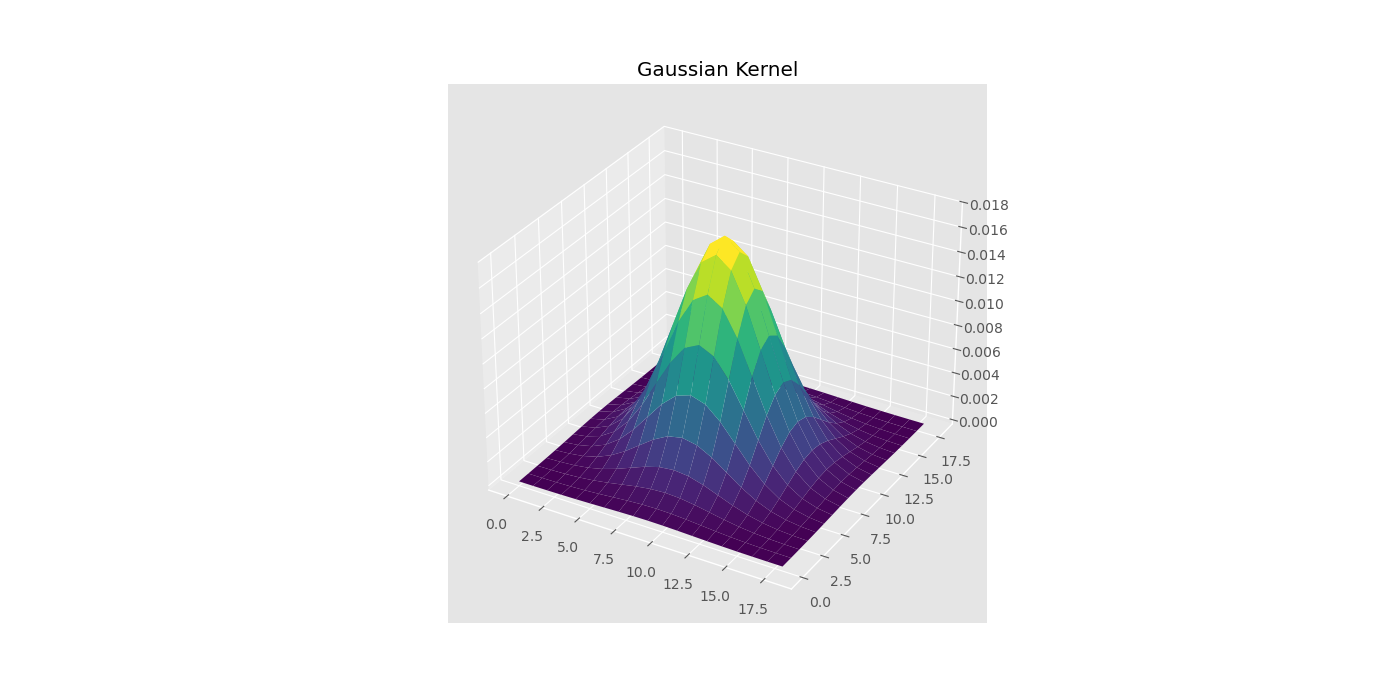

In [38]:
sigma = 3.0

one_dir = np.ceil(3 * sigma)
# kernel_width = 2 * one_dir + 1
idx = np.arange(-one_dir, one_dir + 1)

X, Y = np.meshgrid(idx, idx)
kernel = 1 / (2 * np.pi * (sigma**2)) * (np.exp(-(X**2 + Y**2) / (2 * (sigma**2))))

smart_figure = SmartFigure(figsize=(14, 7))
fig = smart_figure.get_fig()
ax = fig.add_subplot(projection="3d")
plot_kernel(ax, kernel, title="Gaussian Kernel")
display(fig.canvas)